<a href="https://colab.research.google.com/github/rohitpaul23/kaggleAssign/blob/main/FMnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fasion MNIST Dataset Classification

In [ ]:
!pip install opendatasets scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import torch
import os
import opendatasets as od
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

In [ ]:
import torchvision.transforms as transforms
from torch.utils.data import random_split

## Downloading and processing Fashion MNIST Dataset

In [ ]:
from torchvision.datasets import FashionMNIST

In [ ]:
fashionDataset = FashionMNIST(root='data/', download=True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [ ]:
len(fashionDataset)

60000

In [ ]:
test_dataset = FashionMNIST(root='data/', train=False)
len(test_dataset)

10000

In [ ]:
fashionDataset[0]

(<PIL.Image.Image image mode=L size=28x28 at 0x7F8A4A0CB790>, 9)

Label: 9


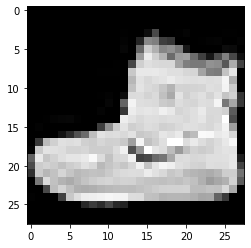

In [ ]:
image, label = fashionDataset[0]
plt.imshow(image, cmap='gray')
print('Label:', label)

Label: 0


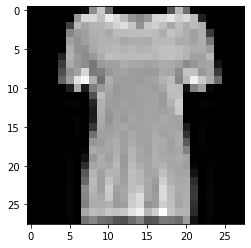

In [ ]:
image, label = fashionDataset[10]
plt.imshow(image, cmap='gray')
print('Label:', label)

In [ ]:
import torchvision.transforms as transforms

In [ ]:
fashionTensorDataset = FashionMNIST(root='data/', 
                      train=True,
                      transform=transforms.ToTensor())

In [ ]:
fashionTensorDataset[0][0].shape

torch.Size([1, 28, 28])

In [ ]:
fashion_train_ds, fashion_val_ds = random_split(fashionTensorDataset, [50000, 10000])
len(fashion_train_ds), len(fashion_val_ds)

(50000, 10000)

In [ ]:
batch_size = 128

fashion_train_loader = DataLoader(fashion_train_ds, batch_size, shuffle=True)
fashion_val_loader = DataLoader(fashion_val_ds, batch_size)

## Using Logistic Regression

In [ ]:
fashionTensorDataset[0][0].shape

torch.Size([1, 28, 28])

In [ ]:
import torch.nn as nn

input_size = 28*28
output_size = 10

input_size, output_size

(784, 10)

In [ ]:
class logistic_model(nn.Module):
    def __init__(self, input_size, output_size):
      super().__init__()
      self.input_size= input_size
      self.output_size = output_size
      self.linear = nn.Linear(input_size, output_size)

    def forward(self, data):
      data = data.reshape(-1, self.input_size)
      out = self.linear(data)
      return out

In [ ]:
model = logistic_model(input_size, output_size)

In [ ]:
model.linear

Linear(in_features=784, out_features=10, bias=True)

In [ ]:
model.linear.weight.shape

torch.Size([10, 784])

In [ ]:
for images, labels in fashion_train_loader:
    print(images.shape)
    out = model(images)
    break

out.shape, out[0]

torch.Size([128, 1, 28, 28])


(torch.Size([128, 10]),
 tensor([-0.0616,  0.0947,  0.2822, -0.7157, -0.2267, -0.6758, -0.0595, -0.2755,
          0.2779, -0.0084], grad_fn=<SelectBackward0>))

In [ ]:
import torch.nn.functional as F

Defining the accuracy function using softmax concept

In [ ]:
def accuracy(outs, labels):
  probs = F.softmax(outs, dim=1)
  max_prob, pred = torch.max(probs, dim=1)
  acc = torch.sum(pred == labels)/len(pred)
  return acc

In [ ]:
accuracy(out, labels)

tensor(0.0938)

Using cross entropy as a loss function as it is differentiable

In [ ]:
loss_func = F.cross_entropy

In [ ]:
loss = loss_func(out, labels)
loss

tensor(2.3187, grad_fn=<NllLossBackward0>)

**Combining all the concepts above**

In [ ]:
class final_logistic_model(nn.Module):
    def __init__(self, input_size, output_size):
      super().__init__()
      self.input_size= input_size
      self.output_size = output_size
      self.linear = nn.Linear(input_size, output_size)
        
    def forward(self, data):
      data = data.reshape(-1, self.input_size)
      out = self.linear(data)
      return out
    
    #Used in Training in fit()
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    #Calculating the loss used in evaluate()
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    #Output the loss and accuracy obtained used in evaluate()
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        batch_accs = torch.stack(batch_accs).to(float)
        epoch_acc = torch.mean(batch_accs)      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    #To print the result of evaluate function used in fit()
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    

In [ ]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

Training the Model

In [ ]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    optimizer = opt_func(model.parameters(), lr)
    history = [] 
    
    for epoch in range(epochs):
         
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)

    return history

In [ ]:
fashion_model = final_logistic_model(input_size, output_size)

In [ ]:
result0 = evaluate(fashion_model, fashion_val_loader)
result0

{'val_acc': 0.03629351265822785, 'val_loss': 2.3979992866516113}

In [ ]:
history1 = fit(10, 0.001, fashion_model, fashion_train_loader, fashion_val_loader)

Epoch [0], val_loss: 1.7237, val_acc: 0.6126
Epoch [1], val_loss: 1.4303, val_acc: 0.6577
Epoch [2], val_loss: 1.2622, val_acc: 0.6672
Epoch [3], val_loss: 1.1547, val_acc: 0.6724
Epoch [4], val_loss: 1.0789, val_acc: 0.6813
Epoch [5], val_loss: 1.0230, val_acc: 0.6912
Epoch [6], val_loss: 0.9788, val_acc: 0.7030
Epoch [7], val_loss: 0.9438, val_acc: 0.7100
Epoch [8], val_loss: 0.9146, val_acc: 0.7179
Epoch [9], val_loss: 0.8899, val_acc: 0.7257


In [ ]:
history2 = fit(10, 0.001, fashion_model, fashion_train_loader, fashion_val_loader)

Epoch [0], val_loss: 0.8684, val_acc: 0.7351
Epoch [1], val_loss: 0.8502, val_acc: 0.7375
Epoch [2], val_loss: 0.8335, val_acc: 0.7420
Epoch [3], val_loss: 0.8187, val_acc: 0.7462
Epoch [4], val_loss: 0.8057, val_acc: 0.7499
Epoch [5], val_loss: 0.7936, val_acc: 0.7530
Epoch [6], val_loss: 0.7824, val_acc: 0.7571
Epoch [7], val_loss: 0.7723, val_acc: 0.7608
Epoch [8], val_loss: 0.7631, val_acc: 0.7619
Epoch [9], val_loss: 0.7544, val_acc: 0.7652


In [ ]:
history3 = fit(10, 0.001, fashion_model, fashion_train_loader, fashion_val_loader)

Epoch [0], val_loss: 0.7462, val_acc: 0.7671
Epoch [1], val_loss: 0.7391, val_acc: 0.7678
Epoch [2], val_loss: 0.7319, val_acc: 0.7701
Epoch [3], val_loss: 0.7251, val_acc: 0.7727
Epoch [4], val_loss: 0.7188, val_acc: 0.7740
Epoch [5], val_loss: 0.7132, val_acc: 0.7755
Epoch [6], val_loss: 0.7072, val_acc: 0.7767
Epoch [7], val_loss: 0.7019, val_acc: 0.7780
Epoch [8], val_loss: 0.6971, val_acc: 0.7797
Epoch [9], val_loss: 0.6921, val_acc: 0.7822


In [ ]:
history4 = fit(10, 0.001, fashion_model, fashion_train_loader, fashion_val_loader)

Epoch [0], val_loss: 0.6876, val_acc: 0.7834
Epoch [1], val_loss: 0.6834, val_acc: 0.7834
Epoch [2], val_loss: 0.6790, val_acc: 0.7860
Epoch [3], val_loss: 0.6752, val_acc: 0.7867
Epoch [4], val_loss: 0.6710, val_acc: 0.7892
Epoch [5], val_loss: 0.6675, val_acc: 0.7896
Epoch [6], val_loss: 0.6637, val_acc: 0.7901
Epoch [7], val_loss: 0.6602, val_acc: 0.7909
Epoch [8], val_loss: 0.6569, val_acc: 0.7930
Epoch [9], val_loss: 0.6540, val_acc: 0.7934


In [ ]:
history5 = fit(10, 0.001, fashion_model, fashion_train_loader, fashion_val_loader)

Epoch [0], val_loss: 0.6508, val_acc: 0.7945
Epoch [1], val_loss: 0.6476, val_acc: 0.7958
Epoch [2], val_loss: 0.6447, val_acc: 0.7972
Epoch [3], val_loss: 0.6419, val_acc: 0.7978
Epoch [4], val_loss: 0.6392, val_acc: 0.7986
Epoch [5], val_loss: 0.6367, val_acc: 0.7991
Epoch [6], val_loss: 0.6342, val_acc: 0.7992
Epoch [7], val_loss: 0.6317, val_acc: 0.7997
Epoch [8], val_loss: 0.6294, val_acc: 0.8002
Epoch [9], val_loss: 0.6270, val_acc: 0.8003


In [ ]:
history6 = fit(10, 0.001, fashion_model, fashion_train_loader, fashion_val_loader)

Epoch [0], val_loss: 0.6246, val_acc: 0.8018
Epoch [1], val_loss: 0.6224, val_acc: 0.8022
Epoch [2], val_loss: 0.6203, val_acc: 0.8023
Epoch [3], val_loss: 0.6182, val_acc: 0.8034
Epoch [4], val_loss: 0.6164, val_acc: 0.8026
Epoch [5], val_loss: 0.6141, val_acc: 0.8050
Epoch [6], val_loss: 0.6124, val_acc: 0.8052
Epoch [7], val_loss: 0.6103, val_acc: 0.8054
Epoch [8], val_loss: 0.6085, val_acc: 0.8062
Epoch [9], val_loss: 0.6068, val_acc: 0.8054


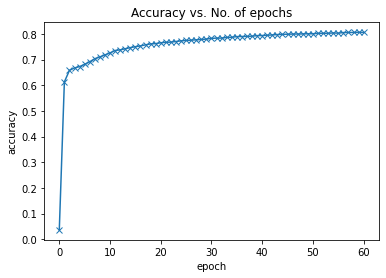

In [ ]:
history = [result0] + history1 + history2 + history3 + history4 + history5 + history6
accuracies = [result['val_acc'] for result in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

After runing 60+ epoch, we are getting a validation accuracy of approx 80%

Prediction on Test Dataset

In [ ]:
fashion_test_dataset = FashionMNIST(root='data/', 
                     train=False,
                     transform=transforms.ToTensor())

Label: 9


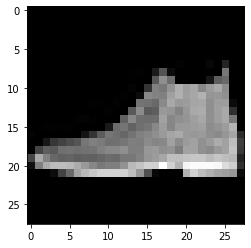

In [ ]:
image, label = fashion_test_dataset[0]
plt.imshow(torch.squeeze(image), cmap='gray')
print('Label:', label)

In [ ]:
def pred_image(data, model):
  y = model(data)
  _, pred = torch.max(y, dim = 1)
  return pred.item()

In [ ]:
pred_image(fashion_test_dataset[0][0], fashion_model)

9

Label: 1


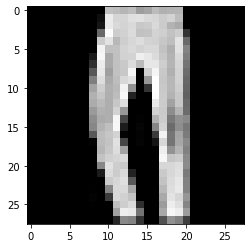

In [ ]:
image, label = fashion_test_dataset[5]
plt.imshow(torch.squeeze(image), cmap='gray')
print('Label:', label)

In [ ]:
pred_image(fashion_test_dataset[5][0], fashion_model)

1

Label: 4


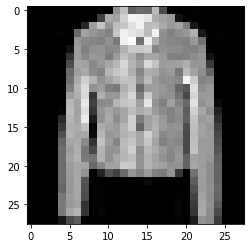

In [ ]:
image, label = fashion_test_dataset[10]
plt.imshow(torch.squeeze(image), cmap='gray')
print('Label:', label)

In [ ]:
pred_image(fashion_test_dataset[10][0], fashion_model)

4

Label: 2


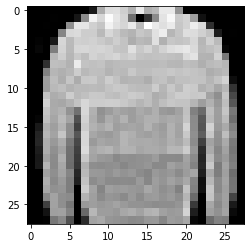

In [ ]:
image, label = fashion_test_dataset[20]
plt.imshow(torch.squeeze(image), cmap='gray')
print('Label:', label)

In [ ]:
pred_image(fashion_test_dataset[20][0], fashion_model)

0

Logistic Regression was able to give 80.23% accuracy

## Using Neural Network

Defining the model

In [ ]:
class neural_Model(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(in_size, hidden_size)
        # output layer
        self.linear2 = nn.Linear(hidden_size, out_size)
        
    def forward(self, xb):
        # Flattening the image tensors
        xb = xb.view(xb.size(0), -1)
        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        # Apply activation function(ReLU)
        out = F.relu(out)
        # Get predictions using output layer
        out = self.linear2(out)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [ ]:
neuralModel = neural_Model(input_size, hidden_size=32, out_size = output_size)

In [ ]:
for t in neuralModel.parameters():
    print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


Enabling GPU, to speed up the computation

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [ ]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
fashion_train_loader = DeviceDataLoader(fashion_train_loader, device)
fashion_val_loader = DeviceDataLoader(fashion_val_loader, device)

In [ ]:
for xb, yb in fashion_val_loader:
    print('xb.device:', xb.device)
    print('yb:', yb)
    break

xb.device: cuda:0
yb: tensor([8, 0, 9, 1, 5, 5, 9, 7, 9, 4, 1, 0, 3, 7, 9, 8, 7, 2, 6, 4, 3, 6, 6, 2,
        2, 9, 2, 9, 0, 9, 3, 4, 8, 5, 9, 6, 0, 2, 5, 6, 1, 6, 0, 7, 6, 6, 6, 6,
        9, 7, 0, 6, 4, 5, 1, 7, 7, 4, 7, 7, 2, 7, 1, 1, 8, 9, 9, 0, 1, 1, 4, 0,
        1, 3, 5, 4, 9, 2, 8, 5, 2, 6, 8, 6, 4, 2, 8, 8, 8, 0, 4, 8, 2, 1, 1, 5,
        5, 0, 2, 9, 6, 9, 0, 3, 1, 4, 1, 7, 7, 7, 3, 6, 9, 6, 2, 3, 0, 7, 3, 8,
        4, 4, 2, 0, 9, 9, 2, 8], device='cuda:0')


Training the model

In [ ]:
def evaluate(model, val_loader):
    """Evaluate the model's performance on the validation set"""
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    """Train the model using gradient descent"""
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
neuralModel = neural_Model(input_size, hidden_size=32, out_size = output_size)
to_device(neuralModel, device)

neural_Model(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [ ]:
history = [evaluate(neuralModel, fashion_val_loader)]
history

[{'val_acc': 0.04875395819544792, 'val_loss': 2.2974305152893066}]

In [ ]:
history += fit(5, 0.05, neuralModel, fashion_train_loader, fashion_val_loader)

Epoch [0], val_loss: 0.6222, val_acc: 0.7879
Epoch [1], val_loss: 0.5859, val_acc: 0.7978
Epoch [2], val_loss: 0.4863, val_acc: 0.8312
Epoch [3], val_loss: 0.5092, val_acc: 0.8204
Epoch [4], val_loss: 0.4575, val_acc: 0.8431


In [ ]:
history += fit(5, 0.01, neuralModel, fashion_train_loader, fashion_val_loader)

Epoch [0], val_loss: 0.4429, val_acc: 0.8516
Epoch [1], val_loss: 0.4416, val_acc: 0.8504
Epoch [2], val_loss: 0.4394, val_acc: 0.8488
Epoch [3], val_loss: 0.4418, val_acc: 0.8485
Epoch [4], val_loss: 0.4370, val_acc: 0.8502


In [ ]:
history += fit(5, 0.005, neuralModel, fashion_train_loader, fashion_val_loader)

Epoch [0], val_loss: 0.4329, val_acc: 0.8526
Epoch [1], val_loss: 0.4333, val_acc: 0.8526
Epoch [2], val_loss: 0.4307, val_acc: 0.8536
Epoch [3], val_loss: 0.4318, val_acc: 0.8526
Epoch [4], val_loss: 0.4290, val_acc: 0.8527


Using only 16 epochs, able to get validation accuracy of 84.5%

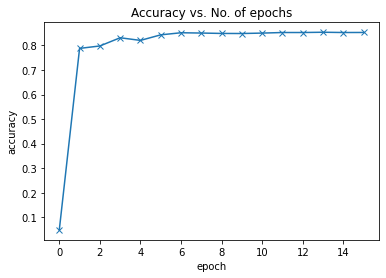

In [ ]:
accuracies = [result['val_acc'] for result in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

Predicting the class for the test image

In [ ]:
def neural_pred_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Label: 4


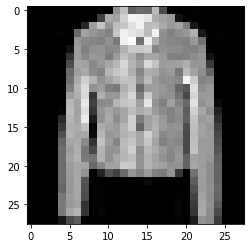

In [ ]:
image, label = fashion_test_dataset[10]
plt.imshow(torch.squeeze(image), cmap='gray')
print('Label:', label)

In [ ]:
neural_pred_image(fashion_test_dataset[10][0], neuralModel)

4

Label: 0


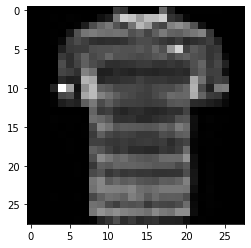

In [ ]:
image, label = fashion_test_dataset[35]
plt.imshow(torch.squeeze(image), cmap='gray')
print('Label:', label)

In [ ]:
neural_pred_image(fashion_test_dataset[35][0], neuralModel)

0

In [ ]:
test_loader = DeviceDataLoader(DataLoader(fashion_test_dataset, batch_size=128), device)
result = evaluate(neuralModel, test_loader)
result

{'val_acc': 0.8407832384109497, 'val_loss': 0.44679778814315796}

By using neural network having single hidden layer, we are able to increase the accuracy from 80.23% to 84.54%

## CONVOLUTIONAL NEURAL NETWORK(CNN)

Defining the model

In [ ]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
class fashionMnistCnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 14 x 14

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 7 x 7

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU(), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
                
    def forward(self, xb):
        return self.network(xb)

In [ ]:
cnnModel = fashionMnistCnnModel()
cnnModel

fashionMnistCnnModel(
  (network): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (15): ReLU()
    (16): Flatten(start_dim=1, end_dim=-1)
    (17): Linear(in_features=4096, out_features=1024, bias=True)
    (18): ReLU()
    (19): Lin

In [ ]:
to_device(cnnModel, device);

In [ ]:
for images, labels in fashion_train_loader:
    print('images.shape:', images.shape)
    out = cnnModel(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([128, 1, 28, 28])
out.shape: torch.Size([128, 10])
out[0]: tensor([-0.0507, -0.0098,  0.0439, -0.0188,  0.0108, -0.0172, -0.0092, -0.0023,
        -0.0389,  0.0286], device='cuda:0', grad_fn=<SelectBackward0>)


Training the model

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
evaluate(cnnModel, fashion_val_loader)

{'val_acc': 0.09612341970205307, 'val_loss': 2.303215503692627}

In [ ]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [ ]:
history = fit(num_epochs, lr, cnnModel, fashion_train_loader, fashion_val_loader, opt_func)

Epoch [0], train_loss: 0.6840, val_loss: 0.4148, val_acc: 0.8477
Epoch [1], train_loss: 0.3515, val_loss: 0.3229, val_acc: 0.8856
Epoch [2], train_loss: 0.2900, val_loss: 0.2837, val_acc: 0.9002
Epoch [3], train_loss: 0.2526, val_loss: 0.2694, val_acc: 0.9015
Epoch [4], train_loss: 0.2222, val_loss: 0.2404, val_acc: 0.9154
Epoch [5], train_loss: 0.1981, val_loss: 0.2406, val_acc: 0.9167
Epoch [6], train_loss: 0.1734, val_loss: 0.2523, val_acc: 0.9149
Epoch [7], train_loss: 0.1571, val_loss: 0.2181, val_acc: 0.9207
Epoch [8], train_loss: 0.1397, val_loss: 0.2557, val_acc: 0.9187
Epoch [9], train_loss: 0.1206, val_loss: 0.2440, val_acc: 0.9201


In [ ]:
history += fit(5, 0.0005, cnnModel, fashion_train_loader, fashion_val_loader, opt_func)

Epoch [0], train_loss: 0.0757, val_loss: 0.2949, val_acc: 0.9268
Epoch [1], train_loss: 0.0537, val_loss: 0.3145, val_acc: 0.9235
Epoch [2], train_loss: 0.0400, val_loss: 0.3598, val_acc: 0.9234
Epoch [3], train_loss: 0.0345, val_loss: 0.3911, val_acc: 0.9232
Epoch [4], train_loss: 0.0287, val_loss: 0.3932, val_acc: 0.9233


In just 15 epoch able to get a validation accuracy of 91.91%

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

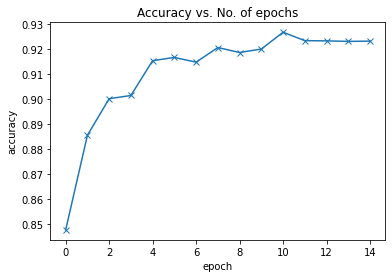

In [ ]:
plot_accuracies(history)

By using Convolutional Neural Network setting, able to get an accuracy of 92% increasing it from 84.5%

## Using the concept of Regularization and ResNet to improve the CNN Model

In [ ]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
def conv_block(in_channels, out_channels, pool=False, stride = 1, padding = 1):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=padding, stride = stride), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResCnnModel(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.conv1 = conv_block(in_channels, 32) 
        self.conv2 = conv_block(32, 64, pool = True)
        self.res1 = nn.Sequential(conv_block(64, 64), conv_block(64, 64))

        self.conv3 = conv_block(64, 128)
        self.conv4 = conv_block(128, 256, pool = True)
        self.res2 = nn.Sequential(conv_block(256, 256), conv_block(256, 256))

        self.conv5 = conv_block(256, 512)
        self.conv6 = conv_block(512, 512, padding = 0)
        self.conv7 = conv_block(512, 512, padding = 0)
        self.res3 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))

        self.classifier = nn.Sequential(nn.MaxPool2d(3), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
                
    def forward(self, xb):
        out = self.conv1(xb) #32x28x28
        out = self.conv2(out) #64x14x14
        out = self.res1(out) + out #64x14x14
        out = self.conv3(out) #128x14x14
        out = self.conv4(out) #256x7x7
        out = self.res2(out) + out #256x7x7
        out = self.conv5(out) #512x7x7
        out = self.conv6(out) #512x5x5
        out = self.conv7(out) #512x3x3
        out = self.res3(out) + out #512x3x3
        out = self.classifier(out)
        return out

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    """Evaluate the model's performance on the validation set"""
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    """Train the model using gradient descent"""
    torch.cuda.empty_cache()
    history = []
    optimizer = opt_func(model.parameters(), max_lr, weight_decay = weight_decay)

    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
      model.train()
      train_losses = []
      lrs = []
        
      # Training Phase 
      for batch in train_loader:
        loss = model.training_step(batch)
        train_losses.append(loss)
        loss.backward()

        # Gradient clipping
        if grad_clip: 
          nn.utils.clip_grad_value_(model.parameters(), grad_clip)

        optimizer.step()
        optimizer.zero_grad()

        # Record & update learning rate
        lrs.append(get_lr(optimizer))
        sched.step()

      # Validation phase
      result = evaluate(model, val_loader)
      result['train_loss'] = torch.stack(train_losses).mean().item()
      result['lrs'] = lrs
      
      model.epoch_end(epoch, result)
      history.append(result)
    return history

In [ ]:
finalModel = ResCnnModel(1, 10)
finalModel

ResCnnModel(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)


In [ ]:
finalModel = to_device(finalModel, device);

In [ ]:
history = [evaluate(finalModel, fashion_val_loader)]

In [ ]:
epochs = 10
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
history += fit_one_cycle(epochs, max_lr, finalModel, fashion_train_loader, fashion_val_loader, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00279, train_loss: 0.4266, val_loss: 0.4204, val_acc: 0.8638
Epoch [1], last_lr: 0.00760, train_loss: 0.3282, val_loss: 0.3837, val_acc: 0.8697
Epoch [2], last_lr: 0.01000, train_loss: 0.2886, val_loss: 0.3159, val_acc: 0.8926
Epoch [3], last_lr: 0.00950, train_loss: 0.2675, val_loss: 0.3825, val_acc: 0.8624
Epoch [4], last_lr: 0.00812, train_loss: 0.2504, val_loss: 0.3717, val_acc: 0.8734
Epoch [5], last_lr: 0.00611, train_loss: 0.2300, val_loss: 0.2343, val_acc: 0.9164
Epoch [6], last_lr: 0.00389, train_loss: 0.2064, val_loss: 0.2197, val_acc: 0.9248
Epoch [7], last_lr: 0.00188, train_loss: 0.1691, val_loss: 0.1989, val_acc: 0.9262
Epoch [8], last_lr: 0.00050, train_loss: 0.1138, val_loss: 0.1687, val_acc: 0.9416
Epoch [9], last_lr: 0.00000, train_loss: 0.0542, val_loss: 0.1733, val_acc: 0.9427


In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

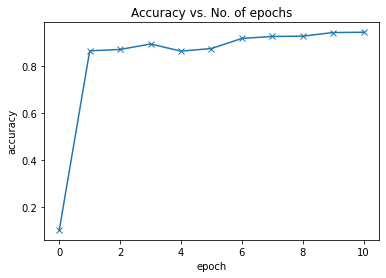

In [ ]:
plot_accuracies(history)

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

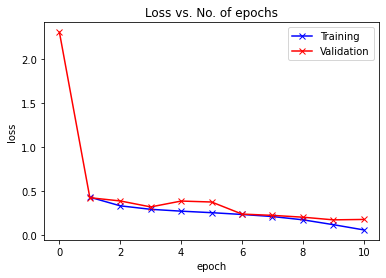

In [ ]:
plot_losses(history)

In [ ]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

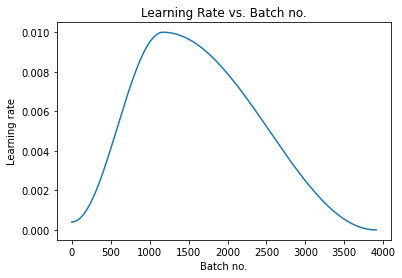

In [ ]:
plot_lrs(history)

By introducing the concept of ResNet and Regularization able to increase the accuracy from 92.3% to 94.27% in just 10 epochs
